# Критерий Манна-Уитнии
Проверим мощность критерий при верной альтернативной гипотезе. Для этого будем сэмплировать выборки из нормальных распределений с разными параметрами.

In [8]:
import numpy as np
from scipy.stats import mannwhitneyu, norm
from tqdm import tqdm
from statsmodels.stats.proportion import proportion_confint

In [10]:
distr_one = norm(loc=1, scale=1)
distr_two = norm(loc=3, scale=1)
distr_three = norm(loc=1, scale=3)
n_size = 1000

**1. Случай: есть смещение выборок**

In [14]:
bad_cnt = 0
for i in tqdm(range(n_size)):
    test = distr_one.rvs(1000)
    control = distr_two.rvs(1000)

    p_value = mannwhitneyu(test, control, alternative='two-sided').pvalue

    if p_value < 0.05:
        bad_cnt += 1

left_bound, right_bound = proportion_confint(nobs=n_size, count=bad_cnt, alpha=0.05, method='wilson')
print(f'CI: {left_bound} -- {right_bound}')
print(f'Power = {bad_cnt / n_size}')

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1751.86it/s]

CI: 0.996173241514445 -- 1.0
Power = 1.0


**2. Случай: нет смещения выборок - разная дисперсия**

In [26]:
np.random.seed(8)
bad_cnt = 0
for i in tqdm(range(n_size)):
    test = distr_one.rvs(1000)
    control = distr_three.rvs(1000)

    p_value = mannwhitneyu(test, control, alternative='two-sided').pvalue

    if p_value < 0.05:
        bad_cnt += 1

left, right = proportion_confint(nobs=n_size, count=bad_cnt, alpha=0.05, method='wilson')
print(f'CI: {left} -- {right}')
print(f'Power = {bad_cnt / n_size}')

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1751.71it/s]

CI: 0.05666969535045146 -- 0.08861366343015481
Power = 0.071


Теперь посмотрим как работает критерий Манна-Уитни для экспоненциального распределения и распределения гамма. Будем применять односторонний критерий Манна-Уитни

In [31]:
from scipy.stats import expon, gamma
import matplotlib.pyplot as plt
import seaborn as sns

Text(0, 0.5, 'Плотность распределения')

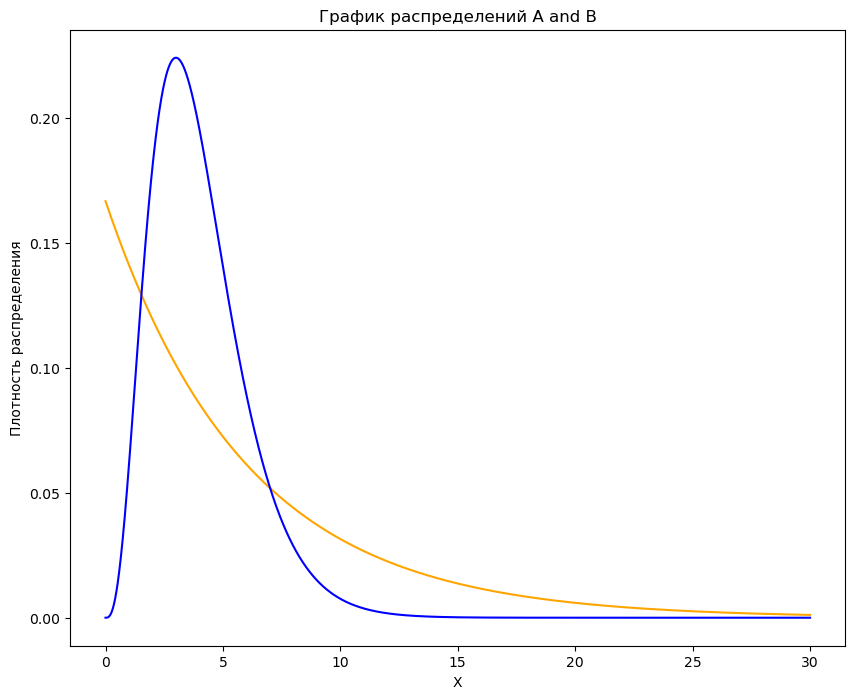

In [41]:
distr_a = expon(loc=0, scale=6)
distr_b = gamma(a=4, scale=1)
x = np.linspace(0, 30, 10000)
plt.figure(figsize=(10,8))
plt.plot(x, distr_a.pdf(x), color='orange', label='A')
plt.plot(x, distr_b.pdf(x), color='blue', label='B')
plt.title('График распределений A and B')
plt.xlabel('Х')
plt.ylabel('Плотность распределения')

Здесь нам интересно понять, какой из графиков будет левее, а какой правее. Так вот проверим это с помощью Монте-Карло и одностороннего критерия Манна-Уитни

In [68]:
n_size = 1000
bad_cnt_less = 0
bad_cnt_greater = 0
for i in tqdm(range(n_size)):
    a_rvs = distr_a.rvs(1000)
    b_rvs = distr_b.rvs(1000)

    p_value_less = mannwhitneyu(a_rvs, b_rvs, alternative='less').pvalue #A<B
    p_value_greater = mannwhitneyu(a_rvs, b_rvs, alternative='greater').pvalue #A>B

    if p_value_less < 0.05:
        bad_cnt_less += 1
    if p_value_greater < 0.05:
        bad_cnt_greater += 1

print(f'Power fo alternative=less (A<B): {np.round(bad_cnt_less / n_size, 2) * 100}%')
print(f'Power fo alternative=greater (A>B): {np.round(bad_cnt_greater / n_size, 2) * 100}%')

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1003.52it/s]

Power fo alternative=less (A<B): 0.0%
Power fo alternative=greater (A>B): 91.0%


In [54]:
distr_a.expect()

6.000000000000001

In [56]:
distr_b.expect()

4.0000000000000036

Манн-Уитни посчитал, что наше оранжевое распределение правее синего, правее в нашем случает значит, что критерий отвергает нулевую гипотезу с альтернативой **greater**, а левее - в сторону альтернативы **less**, то есть в какой из альтернатив больше мощность, в ту сторону будет и сдвинут один график относительно другого

Далее проверим, можно ли применять критерий Манна-Уитни для сравнения средних, медиан и того, что вероятность отклонения одной выборки от другой равна 0.5. Так же будем проверять с помощью Монте-Карло

In [75]:
from scipy.stats import ttest_ind, uniform

In [91]:
bad_cnt_ttest = 0
bad_cnt_mann = 0

for i in tqdm(range(n_size)):
    a = uniform(loc=-1, scale=2).rvs(1000)
    b = uniform(loc=-100, scale=200).rvs(1000)

    pvalue_mann = mannwhitneyu(a, b, alternative='two-sided').pvalue
    pvalue_ttest = ttest_ind(a, b, alternative='two-sided').pvalue

    if pvalue_mann < 0.05:
        bad_cnt_mann += 1
    if pvalue_ttest < 0.05:
        bad_cnt_ttest += 1

?≥print(f'mann-whitney: {bad_cnt_mann / n_size}')

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 909.12it/s]

ttets: 0.033
mann-whitney: 0.088


?Мы видим что Манн-Уитни ошибается в разы чаще в сравнении в т-тестом, а это значит что применять критерий Манн-Уитни для сравнения средних - не целесообразно.